# Introduction
**This is the workspace for the [Machine Learning course](https://www.kaggle.com/learn/machine-learning).**

I've translated the concepts to work with the data in this notebook, the Iowa data. Each page in the Machine Learning course includes instructions for what code to write at that step in the course.

# Iowa Housing price prediction

These are the modules you need.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print(data.describe())
print(test_data.describe())

                Id   MSSubClass      ...             YrSold      SalePrice
count  1460.000000  1460.000000      ...        1460.000000    1460.000000
mean    730.500000    56.897260      ...        2007.815753  180921.195890
std     421.610009    42.300571      ...           1.328095   79442.502883
min       1.000000    20.000000      ...        2006.000000   34900.000000
25%     365.750000    20.000000      ...        2007.000000  129975.000000
50%     730.500000    50.000000      ...        2008.000000  163000.000000
75%    1095.250000    70.000000      ...        2009.000000  214000.000000
max    1460.000000   190.000000      ...        2010.000000  755000.000000

[8 rows x 38 columns]
                Id   MSSubClass     ...            MoSold       YrSold
count  1459.000000  1459.000000     ...       1459.000000  1459.000000
mean   2190.000000    57.378341     ...          6.104181  2007.769705
std     421.321334    42.746880     ...          2.722432     1.301740
min    1461.000000

In [3]:
print(data.columns)
print(test_data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Our target column is SalePrice.

In [4]:
y = data.SalePrice
print(y.head())

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64


In [5]:
X = data.drop(['SalePrice','Id'], axis=1)
test_data_bak = test_data.copy()
print(test_data_bak.shape)
test_data = test_data.drop(['Id'], axis=1)
print(X.head())

(1459, 80)
   MSSubClass MSZoning  LotFrontage      ...       YrSold SaleType SaleCondition
0          60       RL         65.0      ...         2008       WD        Normal
1          20       RL         80.0      ...         2007       WD        Normal
2          60       RL         68.0      ...         2008       WD        Normal
3          70       RL         60.0      ...         2006       WD       Abnorml
4          60       RL         84.0      ...         2008       WD        Normal

[5 rows x 79 columns]


Check datatypes of all the columns.

In [6]:
print(X.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


Let's handle for missing data.

In [7]:
missing_cols = [col for col in X.columns if X[col].isnull().any()]
X = X.drop(missing_cols, axis=1)
test_data = test_data.drop(missing_cols, axis=1)

We should convert the categorical data, i.e., object datatypes into numerical data. It might contain important useful features. The number of categories in a categorical column shouldn't be too high, it may lead to overfitting. 

In [8]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64','float64']]
low_cardinality_cols = [col for col in X.columns if X[col].nunique() < 10 and X[col].dtype == 'object']
train_X = X[numeric_cols + low_cardinality_cols]
test_X = test_data[numeric_cols + low_cardinality_cols] 

Let's get dummies.

In [9]:
train_X_dummies = pd.get_dummies(train_X)
test_X_dummies = pd.get_dummies(test_X)
print(train_X_dummies.shape)
print(test_X_dummies.shape)

(1460, 159)
(1459, 148)


We need to make the number of columns same for making them usable by the model.

In [10]:
final_train, final_test = train_X_dummies.align(test_X_dummies, join="inner", axis=1)
print(final_train.shape)
print(final_test.shape)
print(final_train.columns)
print(final_test.columns)

(1460, 148)
(1459, 148)
Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=148)
Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=148)


Function for finding MAE through Cross Validation Scores.

In [11]:
def get_mae_by_cv(X, y):
    return (-1)*cross_val_score(RandomForestRegressor(50), X, y, scoring="neg_mean_absolute_error").mean()

In [12]:
print(get_mae_by_cv(final_train, y))

18045.0925155835


We can use pipelines instead of the commented lines above for imputing.

In [13]:
xgb_pipeline = make_pipeline(Imputer(), XGBRegressor())
xgb_pipeline.fit(final_train, y)
cv_results_xgb = (-1)*cross_val_score(xgb_pipeline, final_train, y, scoring="neg_mean_absolute_error").mean()
print("XGB",cv_results_xgb)
xgb_pipeline_parameterized = make_pipeline(Imputer(), XGBRegressor(n_estimators=135, learning_rate=0.05))
xgb_pipeline_parameterized.fit(final_train, y)
cv_results_xgb_parameterized = (-1)*cross_val_score(xgb_pipeline_parameterized, final_train, y, scoring="neg_mean_absolute_error").mean()
print("XGB_parameterized",cv_results_xgb_parameterized)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was 

XGB 16545.598914080038


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was 

XGB_parameterized 16950.46427971304


Let's predict.

In [14]:
predicted_values = xgb_pipeline_parameterized.predict(final_test)

In [15]:
print(*list(final_train.columns),sep='\n') #LotArea, OverallQual, YearBuilt
analyse_these_cols = ['LotArea','OverallQual','YearBuilt']

MSSubClass
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
MSZoning_C (all)
MSZoning_FV
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Grvl
Street_Pave
LotShape_IR1
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_Bnk
LandContour_HLS
LandContour_Low
LandContour_Lvl
Utilities_AllPub
LotConfig_Corner
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Gtl
LandSlope_Mod
LandSlope_Sev
Condition1_Artery
Condition1_Feedr
Condition1_Norm
Condition1_PosA
Condition1_PosN
Condition1_RRAe
Condition1_RRAn
Condition1_RRNe
Condition1_RRNn
Condition2_Artery
Condition2_Feedr
Condition2_Norm
Condition2_PosA
Condition2_PosN
BldgType_1Fam
BldgType_2fmCon
BldgType_Duplex
BldgType_Twnhs
BldgType

We can only plot dependency graphs if we had already modelled and fitted our training data w.r.t. those features to be examined. And, let's use pipelines.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


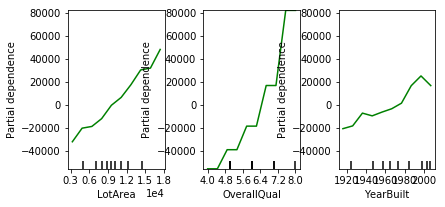

In [16]:
training_col_under_analysis = final_train[analyse_these_cols]
gbmodel = GradientBoostingRegressor()
gb_pipeline = make_pipeline(Imputer(), gbmodel)
gb_pipeline.fit(training_col_under_analysis, y)
plots = plot_partial_dependence(gbmodel, 
                                features=[0,1,2], 
                                X = training_col_under_analysis, 
                                feature_names = analyse_these_cols, 
                                grid_resolution=10)

In [17]:
my_submission = pd.DataFrame({'Id': test_data_bak.Id, 'SalePrice': predicted_values})

In [18]:
my_submission.to_csv('submission.csv', index=False)

**Ask me in case if you needed any help. **

**Check the course contents. [ML Course Index](https://www.kaggle.com/learn/machine-learning)**